In [1]:
import sqlite3
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

In [2]:
cnx = sqlite3.connect('database.sqlite')

In [3]:
df= pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [4]:
print(df)

            id  player_fifa_api_id  player_api_id                 date  \
0            1              218353         505942  2016-02-18 00:00:00   
1            2              218353         505942  2015-11-19 00:00:00   
2            3              218353         505942  2015-09-21 00:00:00   
3            4              218353         505942  2015-03-20 00:00:00   
4            5              218353         505942  2007-02-22 00:00:00   
...        ...                 ...            ...                  ...   
183973  183974              102359          39902  2009-08-30 00:00:00   
183974  183975              102359          39902  2009-02-22 00:00:00   
183975  183976              102359          39902  2008-08-30 00:00:00   
183976  183977              102359          39902  2007-08-30 00:00:00   
183977  183978              102359          39902  2007-02-22 00:00:00   

        overall_rating  potential preferred_foot attacking_work_rate  \
0                 67.0       71.0      

In [5]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


#### Creating Target variable:

In [6]:
target = df.pop('overall_rating')

In [7]:
df.shape

(183978, 41)

In [8]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

#### Imputing target funtion :

In [9]:
target.isnull().values.sum()

836

In [10]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

<IPython.core.display.Javascript object>


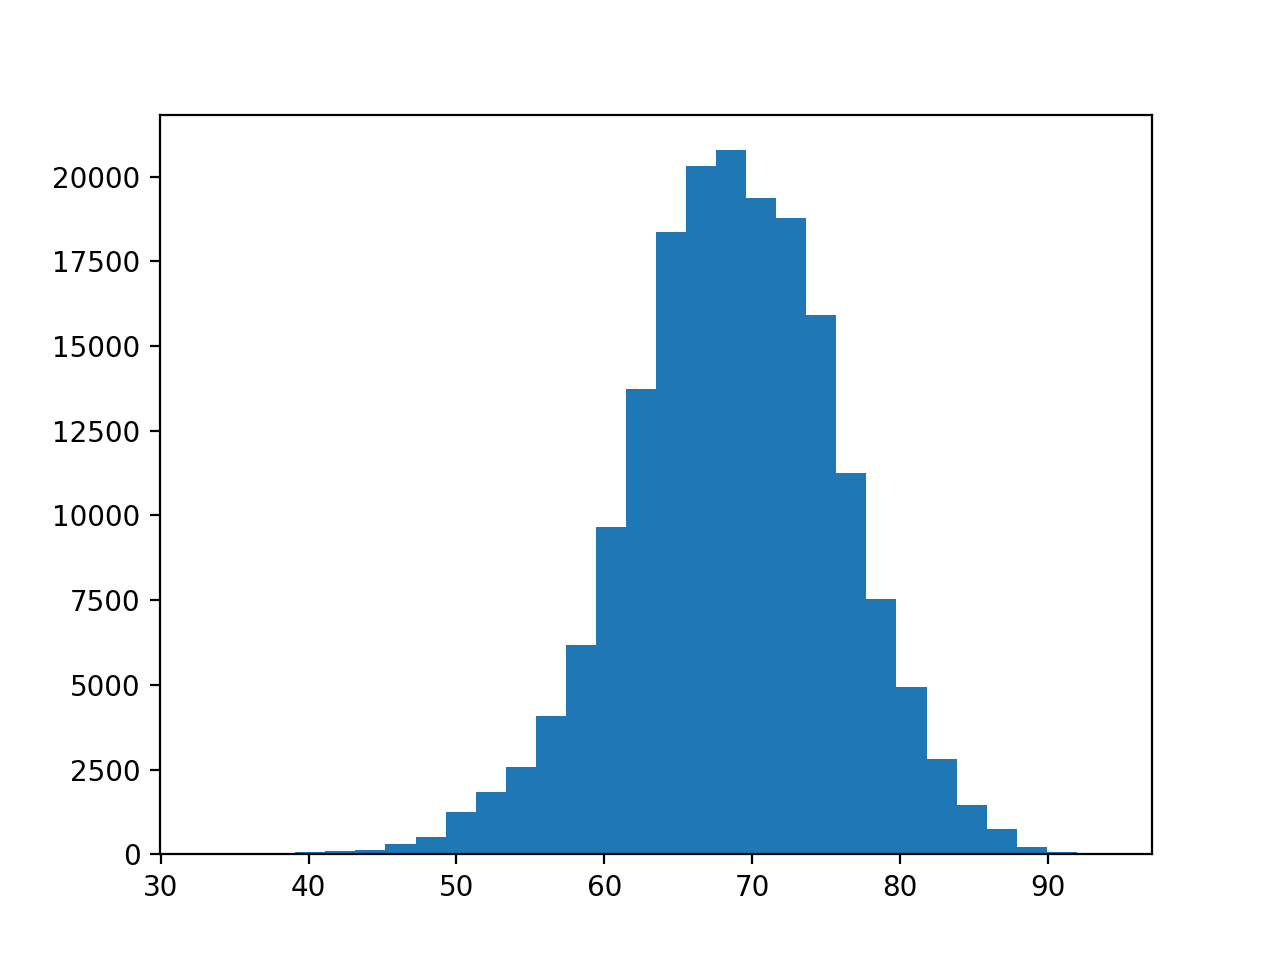

(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <BarContainer object of 30 artists>)

In [11]:
plt.hist(target, 30, range=(33, 94))

It's almost normal distribution so we can impute mean value for missing value in target.

In [12]:
y = target.fillna(target.mean())

In [13]:
y.isnull().values.any()

False

#### Data Exploration :

In [14]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [15]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}..{typ}".format(col=col, unique_cat=unique_cat, typ=df[col].dtype))

id--> 183978..int64
player_fifa_api_id--> 11062..int64
player_api_id--> 11060..int64
date--> 197..object
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..

In [16]:
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
X = dummy_df.drop(['id', 'date'], axis=1)

#### Feature selection :

As tree model doesn't gets affected by missing values present in data set. but feature selection by SelectFromModel can not be done on datasets that carries null value. Therefore, we should also perform imputation on dataset.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
#imputing null value of each column with the mean of that column

imput = SimpleImputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [20]:
#finding feature_importance for feature selection. from it we'll be able to decide threshold value

model = XGBRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)

[0.0112063  0.01328359 0.16840546 0.01479726 0.00693286 0.02923344
 0.02684482 0.00141261 0.01633997 0.00142012 0.00089428 0.00336454
 0.05596948 0.00311885 0.00745351 0.00146221 0.3133247  0.00111532
 0.02715905 0.00230193 0.00448559 0.02142001 0.00503636 0.0047115
 0.01690763 0.01669931 0.00246637 0.00140508 0.02284729 0.05204851
 0.00592539 0.02880221 0.02403816 0.00703669 0.03812633 0.022119
 0.00037242 0.         0.00078061 0.00141978 0.00046924 0.00049927
 0.0007586  0.00086996 0.00040868 0.00098631 0.         0.
 0.         0.00204254 0.00125616 0.         0.00173628 0.
 0.0006331  0.         0.00087684 0.         0.         0.00092218
 0.00059731 0.00364412 0.00161083 0.         0.        ]


In [21]:
selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)
select_X_train.shape

(137983, 19)

#### Scaling the data:

In [22]:
scalar = StandardScaler()
x_scaled_train = scalar.fit_transform(select_X_train)
x_scaled_train

array([[ 1.0567811 ,  2.90118168, -0.37370531, ..., -0.69862488,
        -0.31949444, -0.49199125],
       [ 0.83239093,  1.11023832, -0.67788964, ..., -0.25617622,
        -0.25716519, -0.55033053],
       [ 0.17077907,  1.07420333,  0.38675551, ..., -0.12976231,
        -0.19483593, -0.55033053],
       ...,
       [-2.07758255, -0.8212941 ,  1.2993085 , ...,  0.31268635,
         0.30379811,  0.26641949],
       [ 0.44157109, -0.11639067,  0.99512417, ...,  0.37589331,
         0.36612736,  0.32475878],
       [ 0.22002412, -0.64891505,  1.755585  , ..., -0.69862488,
        -0.50648221, -0.2586341 ]])

In [23]:
x_scaled_test = scalar.fit_transform(select_X_test)
x_scaled_test

array([[ 0.5825465 ,  0.37577743,  1.14364038, ..., -0.69951284,
        -0.19548251, -0.08516627],
       [ 0.7131656 ,  0.14588373, -0.22328168, ..., -0.63646818,
        -0.19548251, -0.2013609 ],
       [ 0.2307514 , -0.78242149, -0.52704214, ..., -0.51037885,
        -0.00935998, -0.37565285],
       ...,
       [ 0.7233016 ,  0.76992259,  0.83987993, ..., -0.13211088,
        -0.13344167, -0.2013609 ],
       [ 0.71524098,  1.61776501,  0.6879997 , ..., -0.25820021,
        -0.50568674, -0.31755554],
       [ 0.90691696,  2.24229255, -1.74208398, ..., -0.25820021,
        -0.38160505, -0.31755554]])

## Training different models :

## 1. Linear Regression :

In [24]:
linear_reg = LinearRegression()
linear_reg.fit(x_scaled_train, y_train)

LinearRegression()

In [25]:
linear_reg.score(x_scaled_test, y_test)

0.8487194680891929

### Hyperparameter Tuning:

In [26]:
cv = ShuffleSplit(random_state=0)   #defining type of cross_validation(shuffle spliting)

param_grid = {'n_jobs': [-1]}     #parameters for model tunning

grid = GridSearchCV(linear_reg, param_grid=param_grid, cv=cv)

In [27]:
grid.fit(select_X_train, y_train) 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=None, train_size=None),
             estimator=LinearRegression(), param_grid={'n_jobs': [-1]})

In [28]:
grid.best_params_

{'n_jobs': -1}

In [29]:
grid.best_estimator_

LinearRegression(n_jobs=-1)

In [30]:
new_linear_reg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
new_linear_reg.fit(x_scaled_train, y_train)

LinearRegression(n_jobs=-1)

In [31]:
new_linear_reg.score(x_scaled_test, y_test)

0.8487194680891929

## 2. Decision Tree :

In [32]:
decision_tree = DecisionTreeRegressor(criterion='mse', random_state=0)         #estimator
decision_tree.fit(x_scaled_train, y_train)

DecisionTreeRegressor(random_state=0)

In [33]:
decision_tree.score(x_scaled_test, y_test)

0.9559434200536528

In [34]:
cv = ShuffleSplit(n_splits=10, random_state=42)        #cross validation

param_grid = {'max_depth': [3, 5, 7, 9, 13],
             'criterion': ['mse', 'friedman_mse']}

grid = GridSearchCV(decision_tree, param_grid=param_grid, cv=cv)

In [35]:
grid.fit(select_X_train, y_train)          #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=None, train_size=None),
             estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [3, 5, 7, 9, 13]})

In [36]:
grid.best_params_

{'criterion': 'friedman_mse', 'max_depth': 13}

In [37]:
grid.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=13, random_state=0)

In [38]:
new_deci_tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=24,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=45,
           splitter='best')
new_deci_tree.fit(x_scaled_train, y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=24, random_state=45)

In [39]:
new_deci_tree.score(x_scaled_test, y_test)

0.9573918653268987

## 3. Random Forest :

In [40]:
rand_forest = RandomForestRegressor(random_state=123)
rand_forest.fit(x_scaled_train, y_train)

RandomForestRegressor(random_state=123)

In [41]:
rand_forest.score(x_scaled_test, y_test)

0.9797116517014308

### Hyperparameter Tuning:

In [42]:
cv = ShuffleSplit(test_size=0.2, random_state=0)

param_grid = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[9, 11, 13]}                 

grid = GridSearchCV(rand_forest, param_grid=param_grid, cv=cv)

In [43]:
grid.fit(x_scaled_train, y_train) 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_depth': [9, 11, 13],
                         'max_features': ['sqrt', 'log2', 10]})

In [44]:
new_rand_forest = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=33,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
new_rand_forest.fit(x_scaled_train, y_train)

RandomForestRegressor(max_depth=33, max_features=10, n_estimators=10, n_jobs=1,
                      random_state=42)

In [45]:
new_rand_forest.score(x_scaled_test, y_test)

0.9787384737336855

## 4. Xgboost regressor :

In [46]:
xgr = XGBRegressor(random_state=42)
xgr.fit(x_scaled_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
xgr.score(x_scaled_test, y_test)

0.9612268302162874

### Hyperparameter Tuning:

In [48]:
cv = ShuffleSplit(n_splits=10, random_state=0)

param_grid = {'max_depth': [5, 7],
              'learning_rate': [0.1, 0.3]}

grid = GridSearchCV(xgr, param_grid=param_grid, cv=cv, n_jobs= -1)

In [49]:
grid.fit(x_scaled_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=None, train_size=None),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=4,
                                    num_parallel_tree=1, random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate

In [50]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
new_xgr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
new_xgr.fit(x_scaled_train, y_train)

[21:14:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, silent=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [52]:
new_xgr.score(x_scaled_test, y_test)

0.9652303415162796

In [53]:
print("""Linear Regressor accuracy is {lin}
DecisionTree Regressor accuracy is {Dec}
RandomForest regressor accuracy is {ran}
XGBoost regressor accuracy is {xgb}""".format(lin=new_linear_reg.score(x_scaled_test, y_test),
                                                       Dec=new_deci_tree.score(x_scaled_test, y_test),
                                                       ran=new_rand_forest.score(x_scaled_test, y_test),
                                                       xgb=new_xgr.score(x_scaled_test, y_test)))

Linear Regressor accuracy is 0.8487194680891929
DecisionTree Regressor accuracy is 0.9573918653268987
RandomForest regressor accuracy is 0.9787384737336855
XGBoost regressor accuracy is 0.9652303415162796


By accuracy comparision performed above we can say hear that Random Forest regressor gives better result than any other model. and it can predict the target function with approx 98% accuracy.